In [5]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt


import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import os
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')

In [6]:
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type', 'crs', 'resolution', 'spatial_dimensions']
dc_products[dc_products['name'].str.contains("pq_albers")][display_columns].set_index('name')

,description,product_type,crs,resolution,spatial_dimensions
name,,,,,
ls5_pq_albers,"Landsat 5 Pixel Quality 25 metre, 100km tile, ...",pqa,EPSG:3577,"(-25, 25)","(y, x)"
ls7_pq_albers,"Landsat 7 Pixel Quality 25 metre, 100km tile, ...",pqa,EPSG:3577,"(-25, 25)","(y, x)"
ls8_pq_albers,"Landsat 8 Pixel Quality 25 metre, 100km tile, ...",pqa,EPSG:3577,"(-25, 25)","(y, x)"


In [82]:
lat1, lon1, buffer_m1 = -36.435, 148.29, 8000
# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2016-01-01', '2016-12-31')
#time_range = ('2017-04-01', '2016-11-30')
resolution = (-25, 25)
landsat_goodquality_prop = 0.3

ndsi_threshold = 0.2
ndvi_threshold = 0.3
ndwi_threshold = 0.15

In [83]:
x, y = geometry.point(lon1, lat1, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m1, x + buffer_m1),
         'y': (y - buffer_m1, y + buffer_m1),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

In [84]:
# Load data
landsat_ds = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query1)

# Set all nodata pixels to `NaN`:
landsat_ds = masking.mask_invalid_data(landsat_ds)
landsat_ds

<xarray.Dataset>
Dimensions:          (time: 46, x: 641, y: 641)
Coordinates:
  * time             (time) datetime64[ns] 2016-01-05T23:50:46 ... 2016-12-29T23:57:06
  * y                (y) float64 -4.067e+06 -4.067e+06 ... -4.083e+06 -4.083e+06
  * x                (x) float64 1.451e+06 1.451e+06 ... 1.467e+06 1.467e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 nan nan nan ... 6.183e+03 6.195e+03
    blue             (time, y, x) float64 nan nan nan ... 5.865e+03 5.882e+03
    green            (time, y, x) float64 nan nan nan ... 5.851e+03 5.858e+03
    red              (time, y, x) float64 nan nan nan ... 5.927e+03 5.915e+03
    nir              (time, y, x) float64 nan nan nan ... 6.077e+03 6.08e+03
    swir1            (time, y, x) float64 nan nan nan ... 2.209e+03 2.231e+03
    swir2            (time, y, x) float64 nan nan nan ... 2.045e+03 2.078e+03
Attributes:
    crs:      EPSG:3577

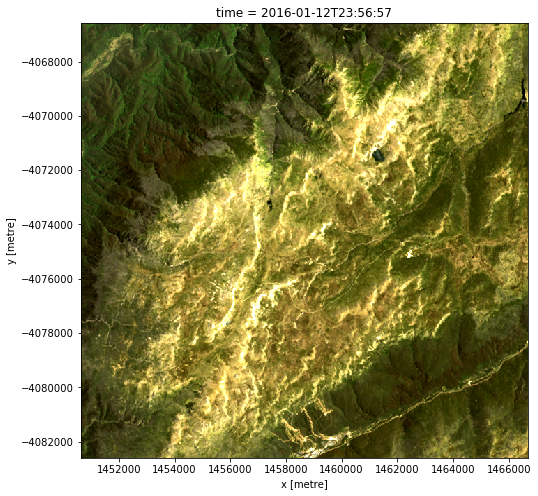

In [13]:
landsat_ds[['red', 'green', 'blue']].isel(time=1).to_array().plot.imshow(robust=True, figsize=(8, 8))

In [14]:
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query1)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 46, x: 641, y: 641)
Coordinates:
  * time          (time) datetime64[ns] 2016-01-05T23:50:46 ... 2016-12-29T23:57:06
  * y             (y) float64 -4.067e+06 -4.067e+06 ... -4.083e+06 -4.083e+06
  * x             (x) float64 1.451e+06 1.451e+06 ... 1.467e+06 1.467e+06
Data variables:
    pixelquality  (time, y, x) int16 0 0 0 0 0 ... 13311 13311 13311 13311 13311
Attributes:
    crs:      EPSG:3577

In [15]:
sensor_pq.pixelquality.values

array([[[    0,     0,     0, ..., 13311, 13311, 13311],
        [    0,     0,     0, ..., 13311, 13311, 13311],
        [    0,     0,     0, ..., 13311, 13311, 13311],
        ...,
        [16127, 16127, 16127, ..., 13311, 13311, 13311],
        [16127, 16127, 16127, ..., 13311, 13311, 13311],
        [16127, 16127, 16127, ..., 13311, 13311, 13311]],

       [[16383, 16383, 16383, ..., 16383, 16383, 16383],
        [16383, 16383, 16383, ..., 16383, 16383, 16383],
        [16383, 16383, 16383, ..., 16383, 16383, 16383],
        ...,
        [16383, 16383, 16383, ..., 16383, 16383, 16383],
        [16383, 16383, 16383, ..., 16383, 16383, 16383],
        [16383, 16383, 16383, ..., 16383, 16383, 16383]],

       [[    0,     0,     0, ..., 13311, 13311, 13311],
        [    0,     0,     0, ..., 13311, 13311, 13311],
        [    0,     0,     0, ..., 13311, 13311, 13311],
        ...,
        [13311, 13311, 13311, ..., 13311, 13311, 13311],
        [13311, 13311, 13311, ..., 13311, 133

In [17]:
dvf = masking.describe_variable_flags(sensor_pq)
dvf

,bits,values,description
blue_saturated,0,"{'0': True, '1': False}",Blue band is saturated
cloud_acca,10,"{'0': 'cloud', '1': 'no_cloud'}",Cloud (ACCA)
cloud_fmask,11,"{'0': 'cloud', '1': 'no_cloud'}",Cloud (Fmask)
cloud_shadow_acca,12,"{'0': 'cloud_shadow', '1': 'no_cloud_shadow'}",Cloud Shadow (ACCA)
cloud_shadow_fmask,13,"{'0': 'cloud_shadow', '1': 'no_cloud_shadow'}",Cloud Shadow (Fmask)
contiguous,8,"{'0': False, '1': True}",All bands for this pixel contain non-null values
ga_good_pixel,"[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",{'16383': True},Best Quality Pixel
green_saturated,1,"{'0': True, '1': False}",Green band is saturated
land_sea,9,"{'0': 'sea', '1': 'land'}",Land or Sea
nir_saturated,3,"{'0': True, '1': False}",NIR band is saturated


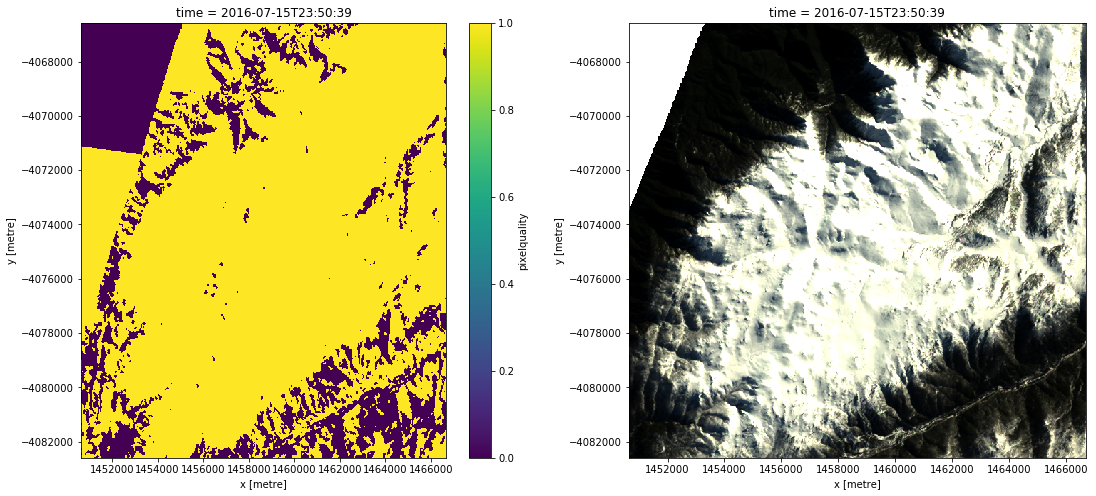

In [75]:
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                )
# good_quality.isel(time=1).plot(figsize=(8,8))

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, 
                         figsize = (18, 8)
                        )
i=24
good_quality.isel(time=i).plot(ax=axes[0])
landsat_ds[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[1])

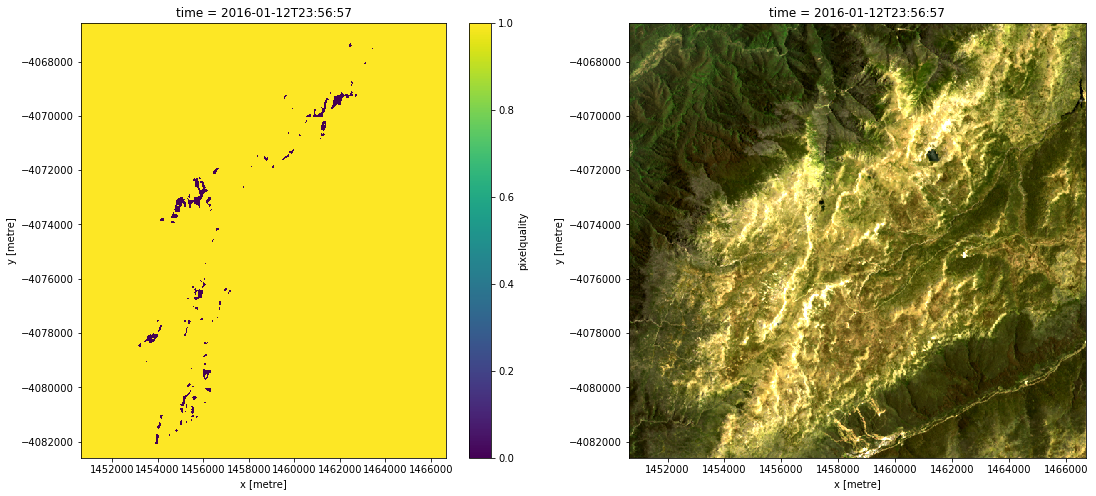

In [33]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, 
                         figsize = (18, 8)
                        )
i=1
good_quality.isel(time=i).plot(ax=axes[0])
landsat_ds[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[1])